In [1]:
import pandas as pd
import numpy as np
import glob
import os

# Define the folder containing the CSV files
folder_path = "/Users/oscarxue/Downloads/SPXdata2/"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize an empty list to store DataFrames
df_list = []

# Process each CSV file
for file in csv_files:
    # Extract expiration date from the filename 
    try:
        filename = os.path.basename(file)
        date_part = filename.split("-exp-")[1].split("-weekly")[0].split("-monthly")[0]  # Extract date
        maturity_date = date_part.strip()  # Clean up the extracted date
    except IndexError:
        print(f"Could not extract date from filename: {filename}")
        continue

    # Read the CSV file
    df = pd.read_csv(file)

    # Add a "Maturity" column with the extracted expiration date
    df["Maturity"] = maturity_date

    # Append to the list
    df_list.append(df)

# Combine all DataFrames into one
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.sort_values(by=["Maturity", "Strike"])
merged_df['Maturity'] = pd.to_datetime(merged_df['Maturity'], errors='coerce')

# Reference date
reference_date = pd.to_datetime("2025-03-06")
# Calculate time to expiration in years
merged_df['Maturity'] = (merged_df['Maturity'] - reference_date).dt.days / 365
# Remove rows where "Strike" contains the unwanted string
merged_df = merged_df[~merged_df["Strike"].str.contains('Downloaded from Barchart.com', na=False)]

# For 'Strike' column: Replace comma only if present
for col in ['Bid', 'Mid', 'Ask', 'Strike']:
    merged_df[col] = (
        merged_df[col]
        .astype(str)              # Ensure all entries are treated as strings
        .str.replace(',', '')     # Remove commas
        .astype(float)            # Convert to float
    )

merged_df['Type'] = merged_df['Type'].replace({'Call': 'call', 'Put': 'put'})
merged_df

,Strike,Moneyness,Bid,Mid,Ask,Last,Change,%Chg,Volume,Open Int,OI Chg,Delta,IV,Type,Last Trade,Maturity
0,5520.0,+4.92%,273.50,274.90,276.30,248.81,unch,unch,0,2,unch,0.98111,44.80%,call,03/05/25,0.002740
100,5520.0,-4.92%,0.85,0.90,0.95,1.37,+1.02,+291.43%,467,847,+210,-0.01823,44.48%,put,11:55 ET,0.002740
1,5525.0,+4.83%,268.50,269.95,271.40,414.47,unch,unch,0,0,unch,0.98009,44.43%,call,03/03/25,0.002740
101,5525.0,-4.83%,0.90,0.95,1.00,1.4,+0.95,+211.11%,361,937,+155,-0.02002,44.47%,put,11:54 ET,0.002740
2,5530.0,+4.75%,263.30,264.85,266.40,276.04,unch,unch,0,10,+4,0.98136,43.01%,call,03/05/25,0.002740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8427,6950.0,+19.74%,974.60,983.60,992.60,0.00,unch,unch,0,0,unch,0.00000,0.00%,put,NaN,0.865753
8328,6975.0,-20.17%,25.70,26.15,26.60,37.00,unch,unch,0,89,unch,0.09275,11.74%,call,03/03/25,0.865753
8428,6975.0,+20.17%,996.50,1005.55,1014.60,785.51,unch,unch,0,1,unch,0.00000,0.00%,put,01/17/25,0.865753
8329,7000.0,-20.60%,23.70,24.15,24.60,24.70,-3.00,-10.83%,4,"3,362",+2,0.08690,11.71%,call,11:29 ET,0.865753


In [2]:
# Separate calls
calls_df = merged_df[merged_df['Type'] == 'call'][['Strike', 'Maturity', 'Mid']]
calls_df = calls_df.rename(columns={'Strike': 'strike', 'Maturity': 'maturity', 'Mid': 'mid'})
Kc = calls_df['strike']
Tc = calls_df['maturity']
C0 = calls_df['mid']

# Separate puts
puts_df = merged_df[merged_df['Type'] == 'put'][['Strike', 'Maturity', 'Mid']]
puts_df = puts_df.rename(columns={'Strike': 'strike', 'Maturity': 'maturity', 'Mid': 'mid'})
Kp = puts_df['strike']
Tp = puts_df['maturity']
P0 = puts_df['mid']


In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator  # Changed import
import matplotlib.pyplot as plt

# Get unique maturities and spot price
T_vectU = np.sort(merged_df['Maturity'].unique())
S0 =  5792  #5805, S0 = 5767
npt = 10000  # Number of grid points
m = 0.15      # Range multiplier
nCol = 5
nRow = int(np.ceil(len(T_vectU)/nCol))
iFwd = []
plt.figure(figsize=(20, 5*nRow))

# Initialize results storage
results = {}
 
# Initialize storage objects BEFORE the loop
xMatch = {T: np.nan for T in T_vectU}
iFwd = []    # List to collect implied forwards

for idx, T in enumerate(T_vectU):
    # Filter maturity data
    calls_T = calls_df[calls_df['maturity'] == T].sort_values('strike')
    puts_T = puts_df[puts_df['maturity'] == T].sort_values('strike')
        
    # Calculate bounds and grid
    minVal = S0 * np.exp(-m * T)
    maxVal = S0 * np.exp(m * T)
    numPoints = int(maxVal - minVal) * npt
    x = np.linspace(minVal, maxVal, numPoints)
        
    # Create interpolators
    call_interp = PchipInterpolator(calls_T['strike'].values, calls_T['mid'].values)
    put_interp = PchipInterpolator(puts_T['strike'].values, puts_T['mid'].values)
    
    # Store results
    C0a = call_interp(x)
    P0a = put_interp(x)
    
    results[T] = {
        'grid': x,
        'calls_interp': C0a,
        'puts_interp': P0a,
        'raw_calls': calls_T,
        'raw_puts': puts_T,
        'bounds': (minVal, maxVal)
    }

    # Find minimum absolute difference
    priceDifference = np.abs(P0a - C0a)
        
    # Find minimum difference location
    minDiff = np.min(priceDifference)
    indexOfMinDiff = np.argmin(priceDifference)
            
    # Get corresponding x value
    xMatch[T] = x[indexOfMinDiff]
    # Get all strikes for current maturity
    current_strikes = np.concatenate([
            calls_T['strike'].values,
            puts_T['strike'].values
    ])
    
    # Append to iFwd vector
    iFwd.extend([xMatch[T]] * len(current_strikes))
        

    
# Convert to numpy arrays
xMatch_array = np.array(list(xMatch.values()))
iFwd_array = np.array(iFwd)
merged_df['Implied Forward'] = iFwd_array


<Figure size 2000x4500 with 0 Axes>

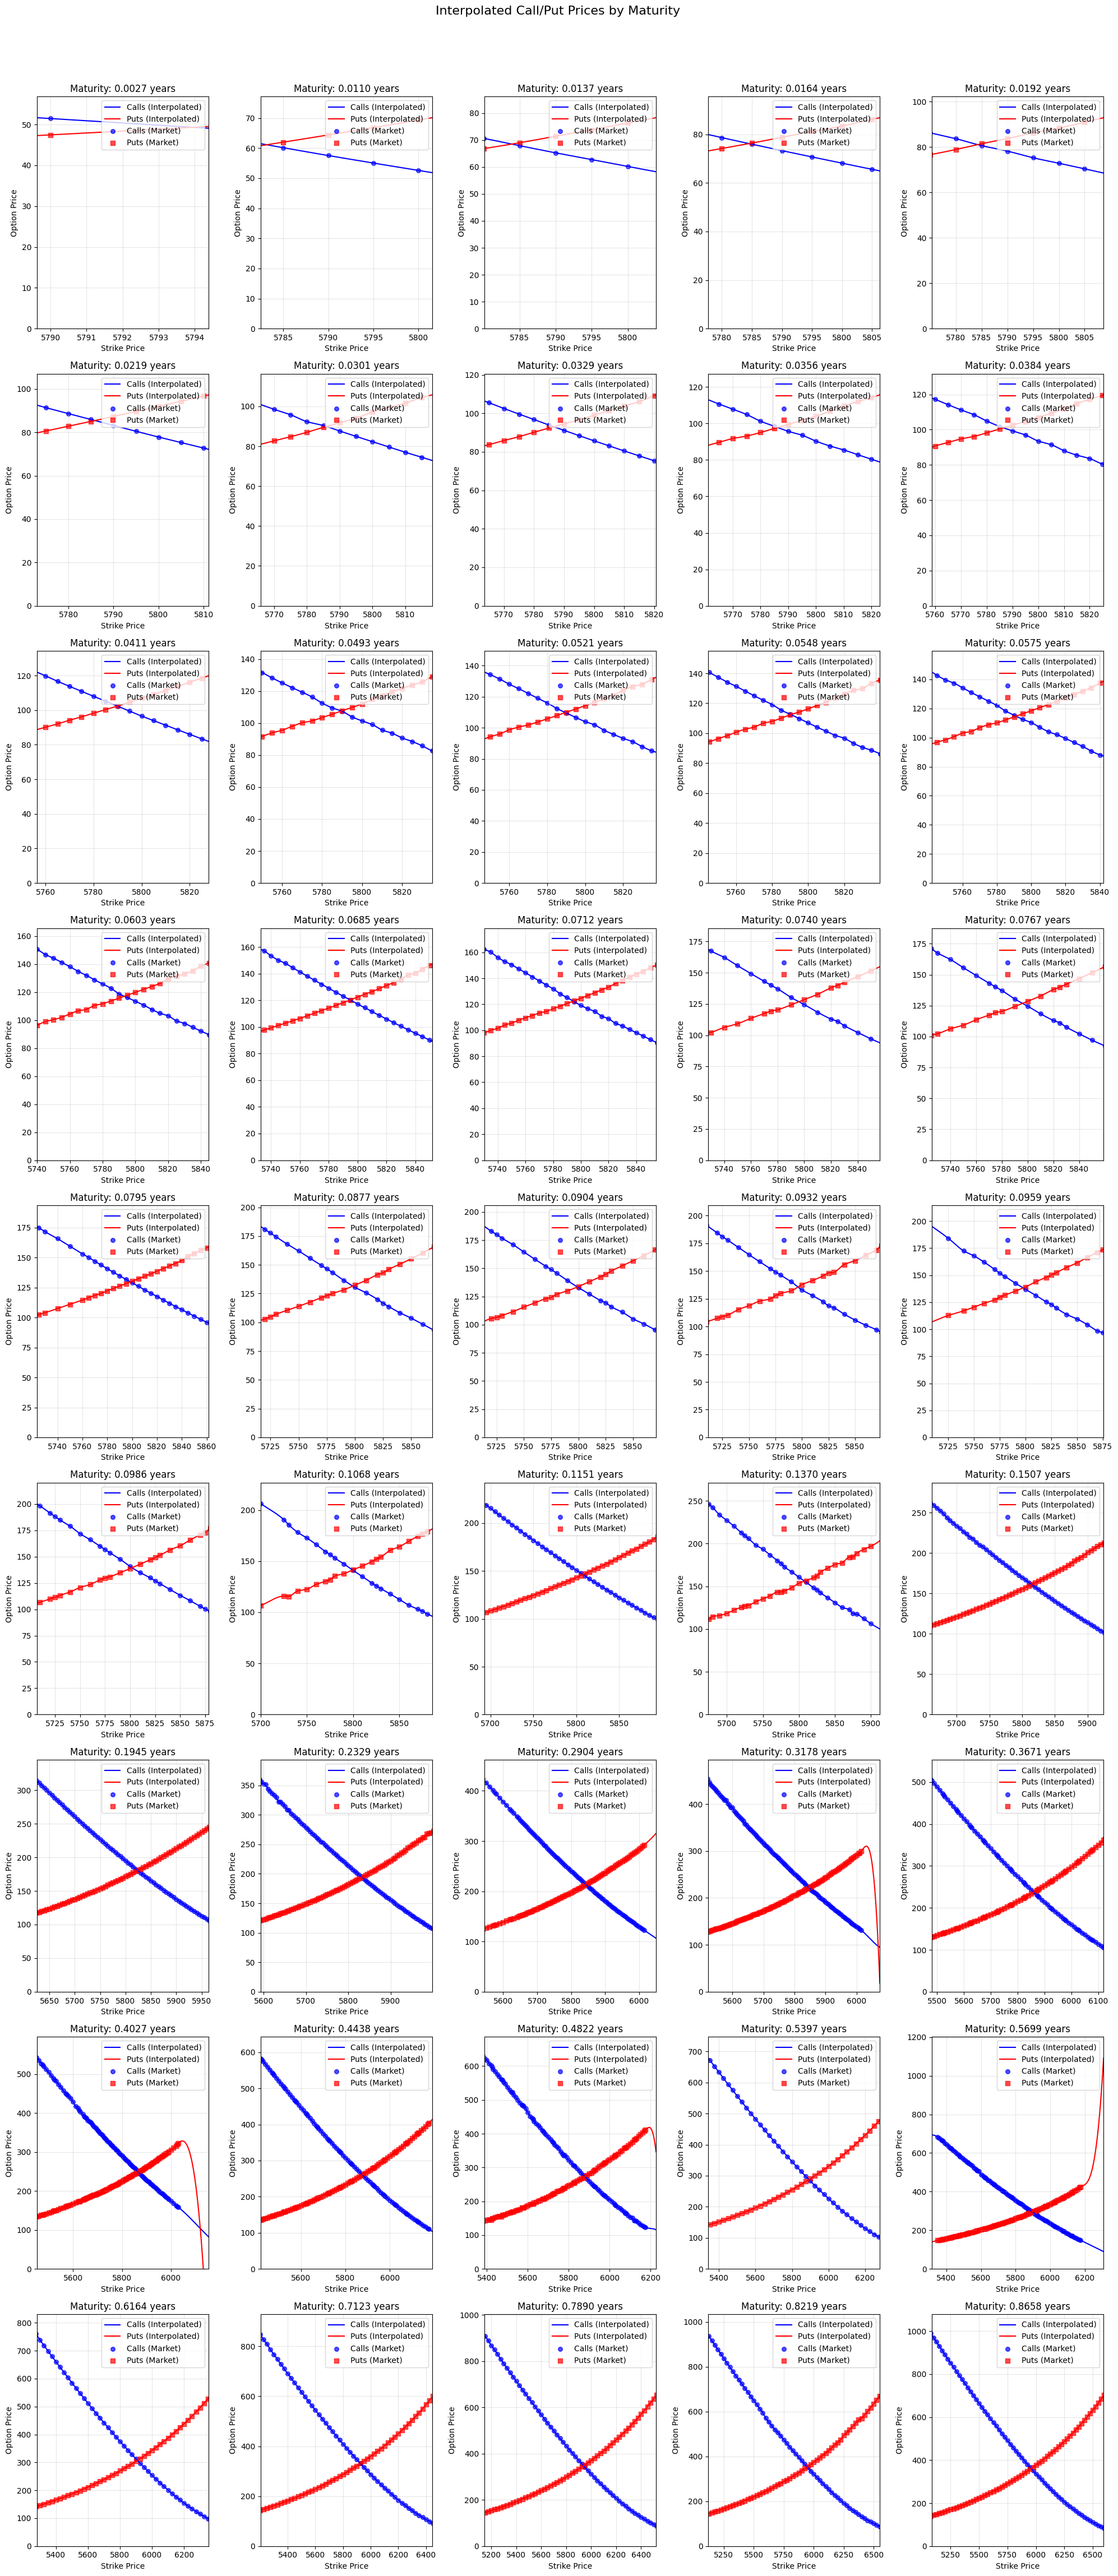

In [4]:
# Create figure with subplot grid
plt.figure(figsize=(20, 5*nRow))
plt.suptitle("Interpolated Call/Put Prices by Maturity", y=1.02, fontsize=16)

for idx, T in enumerate(T_vectU):
    # Get results for current maturity
    res = results[T]
    x = res['grid']
    C0a = res['calls_interp']
    P0a = res['puts_interp']
    raw_calls = res['raw_calls']
    raw_puts = res['raw_puts']
    
    # Create subplot
    ax = plt.subplot(nRow, nCol, idx+1)
    
    # Plot interpolated prices
    ax.plot(x, C0a, 'b-', label='Calls (Interpolated)', linewidth=1.5)
    ax.plot(x, P0a, 'r-', label='Puts (Interpolated)', linewidth=1.5)
    
    # Plot raw market prices
    ax.scatter(raw_calls['strike'], raw_calls['mid'], 
               c='blue', s=30, marker='o', label='Calls (Market)', alpha=0.7)
    ax.scatter(raw_puts['strike'], raw_puts['mid'], 
               c='red', s=30, marker='s', label='Puts (Market)', alpha=0.7)
    
    
    # Formatting
    ax.set_title(f"Maturity: {T:.4f} years")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Option Price")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set sensible axis limits
    ax.set_xlim(res['bounds'][0], res['bounds'][1])
    ax.set_ylim(0, max(np.nanmax(C0a), np.nanmax(P0a)) * 1.1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [5]:
#cost of carry and discount factor
import re

def tenor_to_years(tenor):
    """
    Convert Tenor strings (e.g., '1W', '6M', '10Y') to years.
    """
    match = re.match(r'^(\d+)([A-Za-z]+)$', tenor)
    if not match:
        raise ValueError(f"Invalid Tenor format: {tenor}")
    
    num = int(match.group(1))
    unit = match.group(2).upper()
    
    # Convert Tenor to total days
    if unit == 'W':
        days = num * 7
    elif unit == 'M':
        days = num * 30
    elif unit == 'Y':
        days = num * 360
    else:
        raise ValueError(f"Unknown unit: {unit} in Tenor {tenor}")
    
    # Convert days to years (360-day convention)
    return days / 360

# Load the DataFrame
rates_df = pd.read_csv(r'/Users/oscarxue/Downloads/USDOIS.csv')

# Apply the conversion
rates_df['Tenor'] = rates_df['Tenor'].apply(tenor_to_years)
rates_df['S42 Mid YTM USD OIS Curve 03/06/25 Yield'] = rates_df['S42 Mid YTM USD OIS Curve 03/06/25 Yield'] / 100
rates_df = rates_df.iloc[:, [0, 2]]

# Display results
rates_df
#interest_rate = np.log(merged_df['Implied Forward'] / S0) / merged_df['Maturity']
#merged_df['Interest Rate'] = interest_rate
#r_vect = interest_rate.unique()


,Tenor,S42 Mid YTM USD OIS Curve 03/06/25 Yield
0,0.019444,0.04332
1,0.038889,0.04327
2,0.058333,0.04327
3,0.083333,0.04322
4,0.166667,0.04319
5,0.250000,0.04292
6,0.333333,0.04250
7,0.416667,0.04206
8,0.500000,0.04169
9,0.750000,0.04053


In [6]:
from scipy.interpolate import CubicSpline

# Assuming:
# - rates_df contains columns 'Tenor_Years' and yield values
# - merged_df contains the target maturities

# 1. Prepare the rate curve data (use your actual column name)
x_known = rates_df['Tenor'].values  # Known tenors in years
y_known = rates_df['S42 Mid YTM USD OIS Curve 03/06/25 Yield'].values  # Corresponding yields

# 2. Sort the data for interpolation
sort_idx = np.argsort(x_known)
x_known = x_known[sort_idx]
y_known = y_known[sort_idx]

# 3. Create cubic spline interpolator
cs = CubicSpline(x_known, y_known)

# 4. Get target maturities from merged_df
target_maturities = merged_df['Maturity'].unique()

# 5. Interpolate rates
interpolated_rates = cs(target_maturities)

# 6. Create interpolation DataFrame
interpolation_df = pd.DataFrame({
    'Maturity': target_maturities,
    'Interpolated_Rate': interpolated_rates
})

# 7. Merge back to original DataFrame
merged_df = merged_df.merge(interpolation_df, on='Maturity', how='left')

# Show results
print(interpolation_df.sort_values('Maturity').tail(10))

    Maturity  Interpolated_Rate
35  0.402740           0.042129
36  0.443836           0.041934
37  0.482192           0.041767
38  0.539726           0.041510
39  0.569863           0.041369
40  0.616438           0.041146
41  0.712329           0.040694
42  0.789041           0.040372
43  0.821918           0.040247
44  0.865753           0.040091


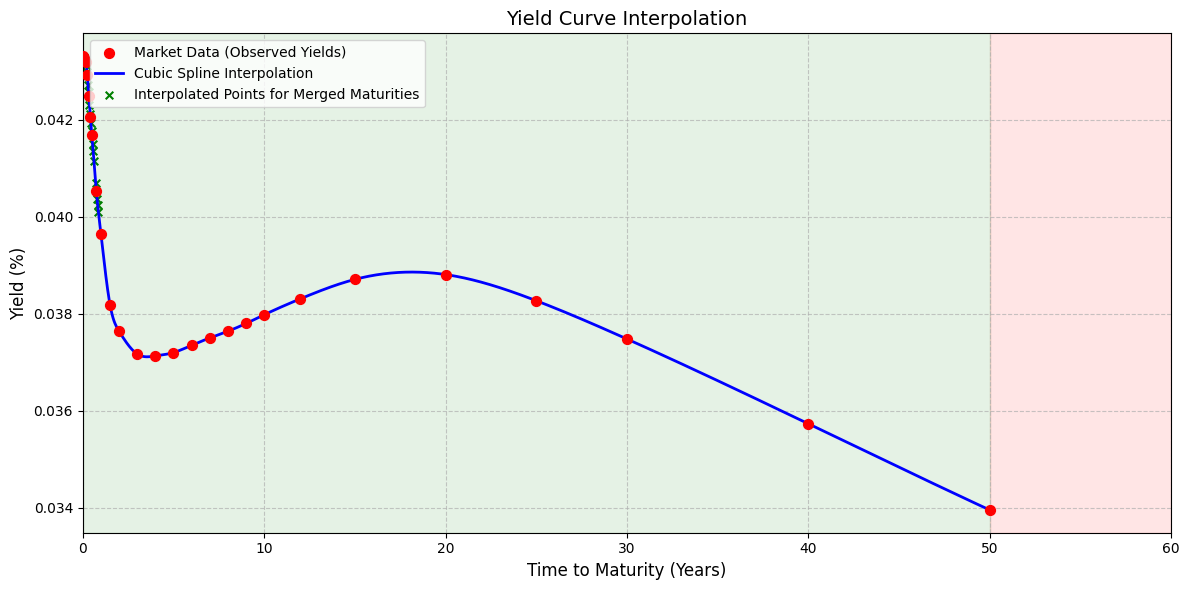

In [7]:
x_known = rates_df['Tenor'].values  # Original tenors (years)
y_known = rates_df['S42 Mid YTM USD OIS Curve 03/06/25 Yield'].values  # Original yields

# Sort the data
sort_idx = np.argsort(x_known)
x_known = x_known[sort_idx]
y_known = y_known[sort_idx]

# Create cubic spline
cs = CubicSpline(x_known, y_known, extrapolate=False)  # Disable extrapolation

# Generate a dense grid for smooth plotting
x_dense = np.linspace(min(x_known), max(x_known), 1000)  # 1000 points for smoothness
y_dense = cs(x_dense)

plt.figure(figsize=(12, 6))

# Plot original data points
plt.scatter(
    x_known, y_known,
    color='red', s=50, zorder=3,
    label='Market Data (Observed Yields)'
)

# Plot interpolated curve
plt.plot(
    x_dense, y_dense,
    linewidth=2, linestyle='-',
    color='blue', label='Cubic Spline Interpolation'
)

# Highlight target maturities from `merged_df`
target_maturities = merged_df['Maturity'].unique()
plt.scatter(
    target_maturities, cs(target_maturities),
    color='green', s=30, marker='x',
    label='Interpolated Points for Merged Maturities'
)

# Formatting
plt.title('Yield Curve Interpolation', fontsize=14)
plt.xlabel('Time to Maturity (Years)', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Annotate key regions
min_tenor, max_tenor = min(x_known), max(x_known)
plt.axvspan(min_tenor, max_tenor, alpha=0.1, color='green', label='Interpolation Range')
plt.axvspan(max_tenor, 1.2*max_tenor, alpha=0.1, color='red', label='Extrapolation Risk')

plt.xlim(0, 1.2*max_tenor)
plt.tight_layout()
plt.show()

In [8]:
import py_vollib.black.implied_volatility
import py_vollib_vectorized

merged_df['Type'] = merged_df['Type'].replace({'call': 'c', 'put': 'p'})
iv = py_vollib_vectorized.vectorized_implied_volatility_black(merged_df['Mid'], merged_df['Implied Forward'], merged_df['Strike'], merged_df['Interpolated_Rate'], merged_df['Maturity'],flag=merged_df['Type'], return_as='series')
merged_df['Calculated Implied Vol'] = iv


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [3777, 3779, 3781, 3783, 3785, 3787, 3789, 3791, 3793, 3795, 3797, 3975, 3977, 3979, 3981, 3983, 3985, 3987, 3989, 3991, 3993, 3995, 4367, 4369, 4371, 4373, 4375, 4377, 4379, 4381, 4383, 4385, 4541, 4543, 4545, 4547, 4549, 4551, 4553, 4555, 4557, 4713, 4715, 4717, 4719, 4721, 4723, 4725, 4727, 4729, 4843, 4845, 4847, 4849, 4851, 4853, 4855, 4857, 4859, 5175, 5177, 5179, 5181, 5183, 5185, 5187, 5189, 5543, 5545, 5547, 5549, 5551, 5553, 5555, 5557, 5559, 7547, 7549, 7551, 7553, 7555, 7557, 7559, 7945, 7947, 7949, 7951, 7953, 7955, 7957, 7959, 8153, 8155, 8157, 8159, 8559]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


In [12]:
merged_df['Calculated Implied Vol'].isna().sum()

np.int64(96)

In [13]:
iv_puts = merged_df[merged_df['Type'] == 'p'][['Calculated Implied Vol']]
iv_calls = merged_df[merged_df['Type'] == 'c'][['Calculated Implied Vol']]

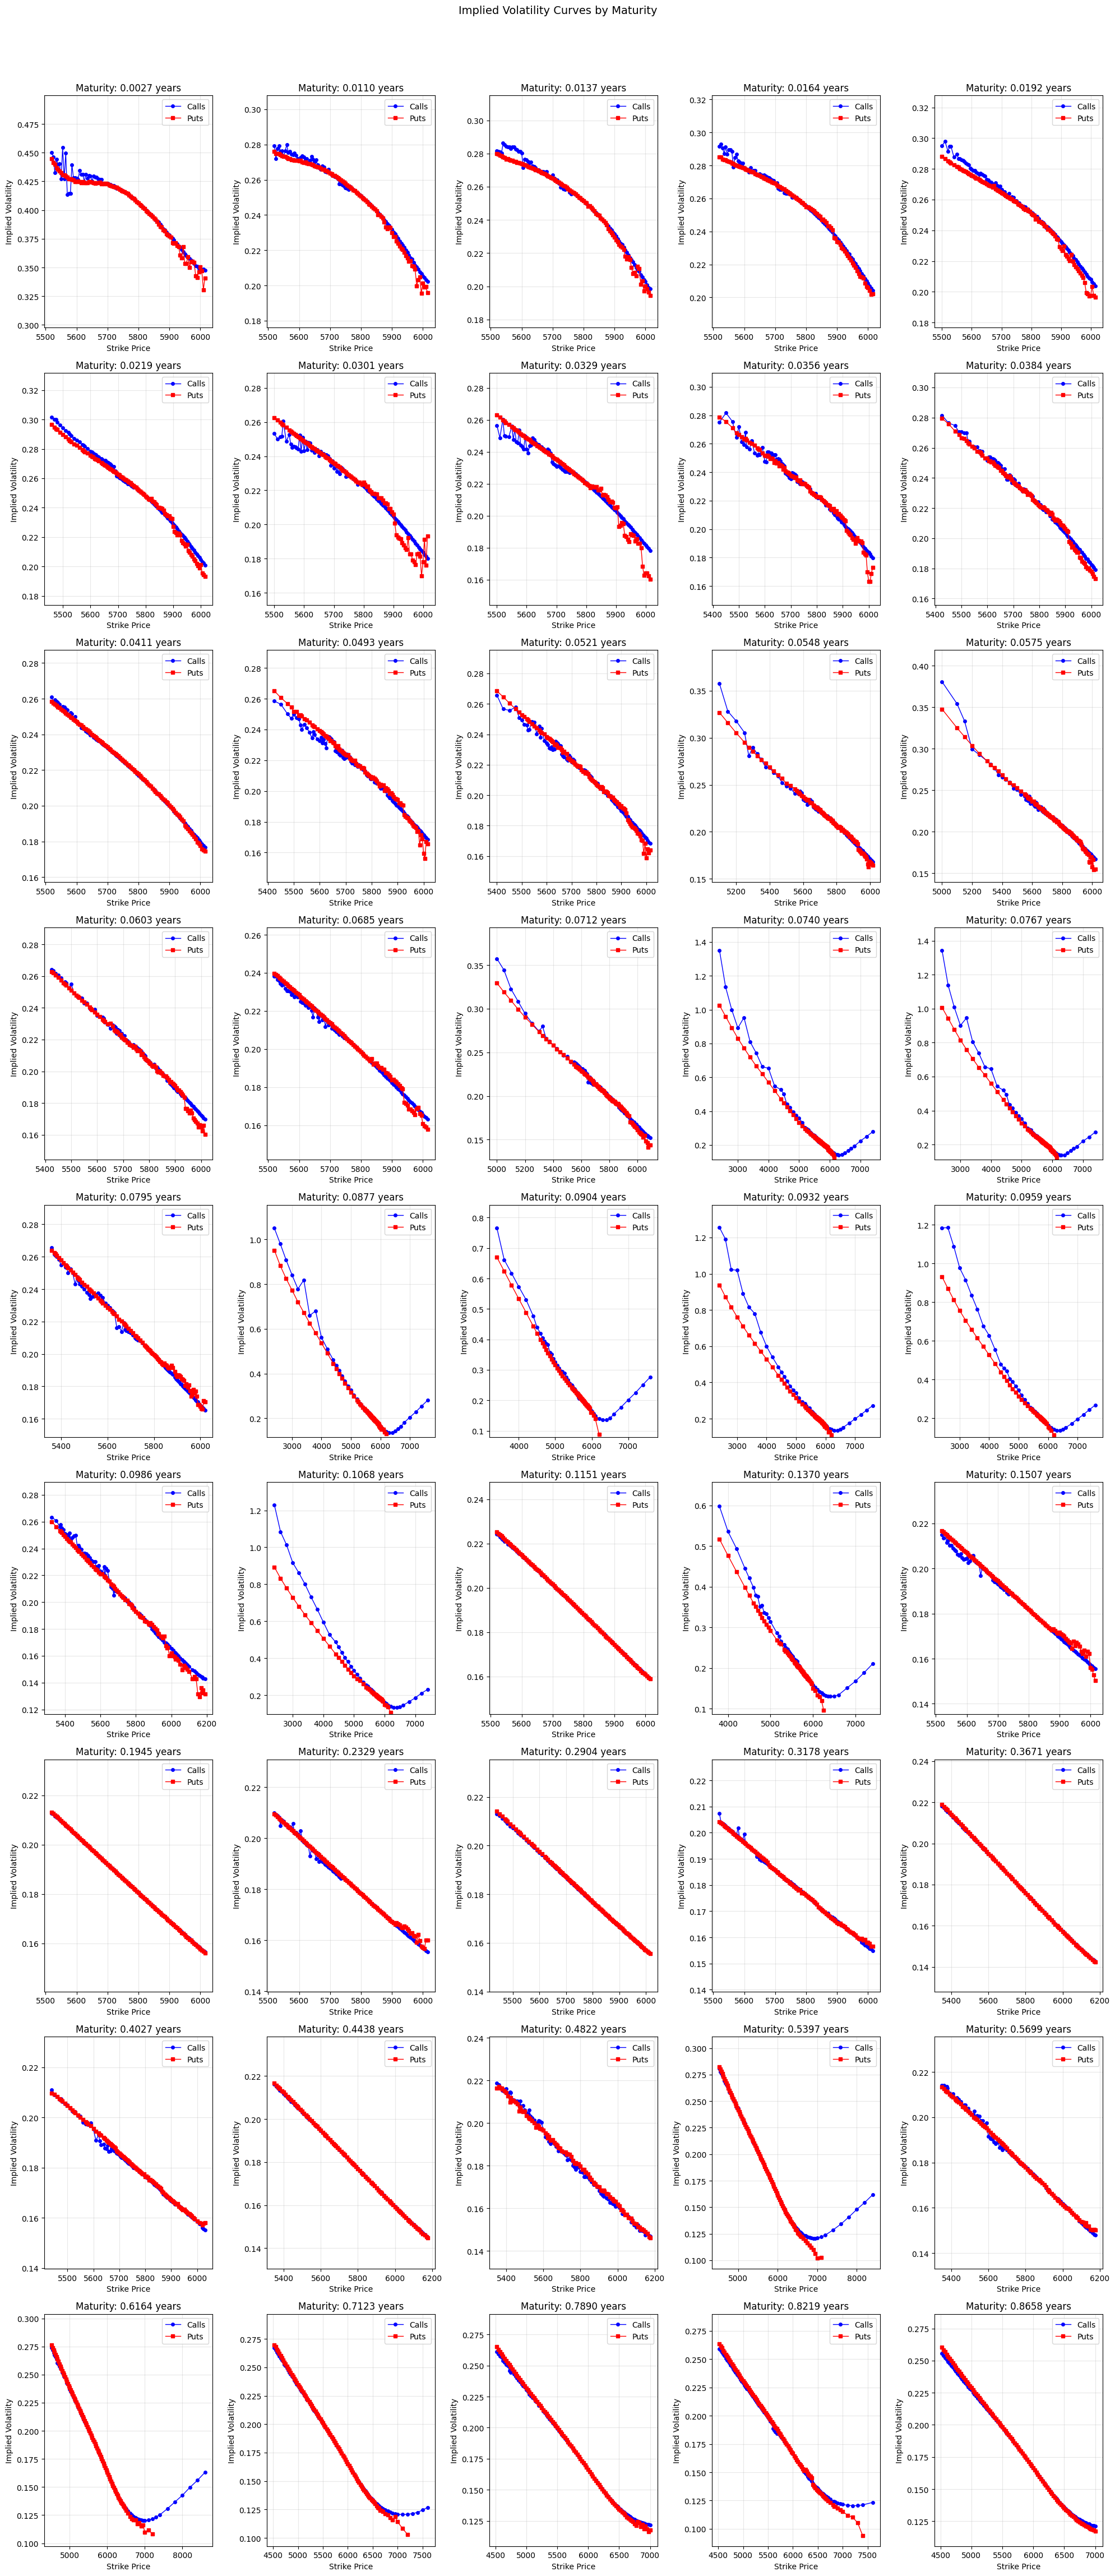

In [14]:
# Create figure with subplot grid
plt.figure(figsize=(20, 5*nRow))
plt.suptitle("Implied Volatility Curves by Maturity", y=1.02, fontsize=14)

for idx, T in enumerate(T_vectU):
    # Filter data for current maturity
    maturity_mask = merged_df['Maturity'] == T
    
    # Get calls and puts for this maturity
    calls = merged_df[(merged_df['Type'] == 'c') & maturity_mask].sort_values('Strike')
    puts = merged_df[(merged_df['Type'] == 'p') & maturity_mask].sort_values('Strike')
    
    # Create subplot
    ax = plt.subplot(nRow, nCol, idx+1)
    
    # Plot call IVs
    ax.plot(calls['Strike'], calls['Calculated Implied Vol'], 
            'b-o', markersize=4, linewidth=1, label='Calls')
    
    # Plot put IVs
    ax.plot(puts['Strike'], puts['Calculated Implied Vol'], 
            'r-s', markersize=4, linewidth=1, label='Puts')
    
    # Formatting
    ax.set_title(f"Maturity: {T:.4f} years")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set consistent axis limits
    all_iv = pd.concat([calls['Calculated Implied Vol'], puts['Calculated Implied Vol']])
    ax.set_ylim(all_iv.min()*0.9, all_iv.max()*1.1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [18]:

bid = merged_df['Bid']  # Convert to numpy array if not already
ask = merged_df['Ask']

# Create removal mask
pos_remove = (
    (merged_df['Ask'] <= merged_df['Bid']) 
    | (merged_df['Ask'] < 3/8) 
    | ((merged_df['Strike'] < merged_df['Implied Forward']) & (merged_df['Type'] == 'c'))  # Remove ITM calls
    | ((merged_df['Implied Forward'] <= merged_df['Strike']) & (merged_df['Type'] == 'p'))  # Remove ITM puts
)

# Filter out unwanted data using boolean indexing
ask = ask[~pos_remove]
bid = bid[~pos_remove]
forward = merged_df['Implied Forward'][~pos_remove]
interest_rate = merged_df['Interpolated_Rate'][~pos_remove]
maturity = merged_df['Maturity'][~pos_remove]
strike = merged_df['Strike'][~pos_remove]
CP_vect = merged_df['Type'][~pos_remove]
mid = merged_df['Mid'][~pos_remove]

# Calculate moneyness metrics
log_moneyness = np.log(strike / forward)
moneyness = strike / forward

implied_volatility_bid = py_vollib_vectorized.vectorized_implied_volatility_black(bid, forward, strike, interest_rate, maturity, CP_vect, return_as='numpy')
implied_volatility_ask = py_vollib_vectorized.vectorized_implied_volatility_black(ask, forward, strike, interest_rate, maturity, CP_vect, return_as='numpy')
implied_volatility     = py_vollib_vectorized.vectorized_implied_volatility_black(mid, forward, strike, interest_rate, maturity, CP_vect, return_as='numpy')

In [ ]:
Matlab_df = pd.DataFrame({'ask' : ask, 'bid' : bid, 'mid' : mid, 'forward' : forward, 'interest_rate' : interest_rate, 'maturity' : maturity, 'strike' : strike, 'CP_vect' : CP_vect, 'implied_volatility_bid' : implied_volatility_bid, 'implied_volatility_ask' : implied_volatility_ask, 'implied_volatility' : implied_volatility, 'log_moneyness' : log_moneyness, 'moneyness' : moneyness})
#Matlab_df.to_excel("Matlab_df.xlsx")

In [28]:
imp_vol = pd.read_csv(r'/Users/oscarxue/Downloads/implied_volatilities.csv')
model_implied_volatility = imp_vol['model_implied_volatility']
model_implied_volatility_ask = imp_vol['model_implied_volatility_ask']
model_implied_volatility_bid = imp_vol['model_implied_volatility_bid']

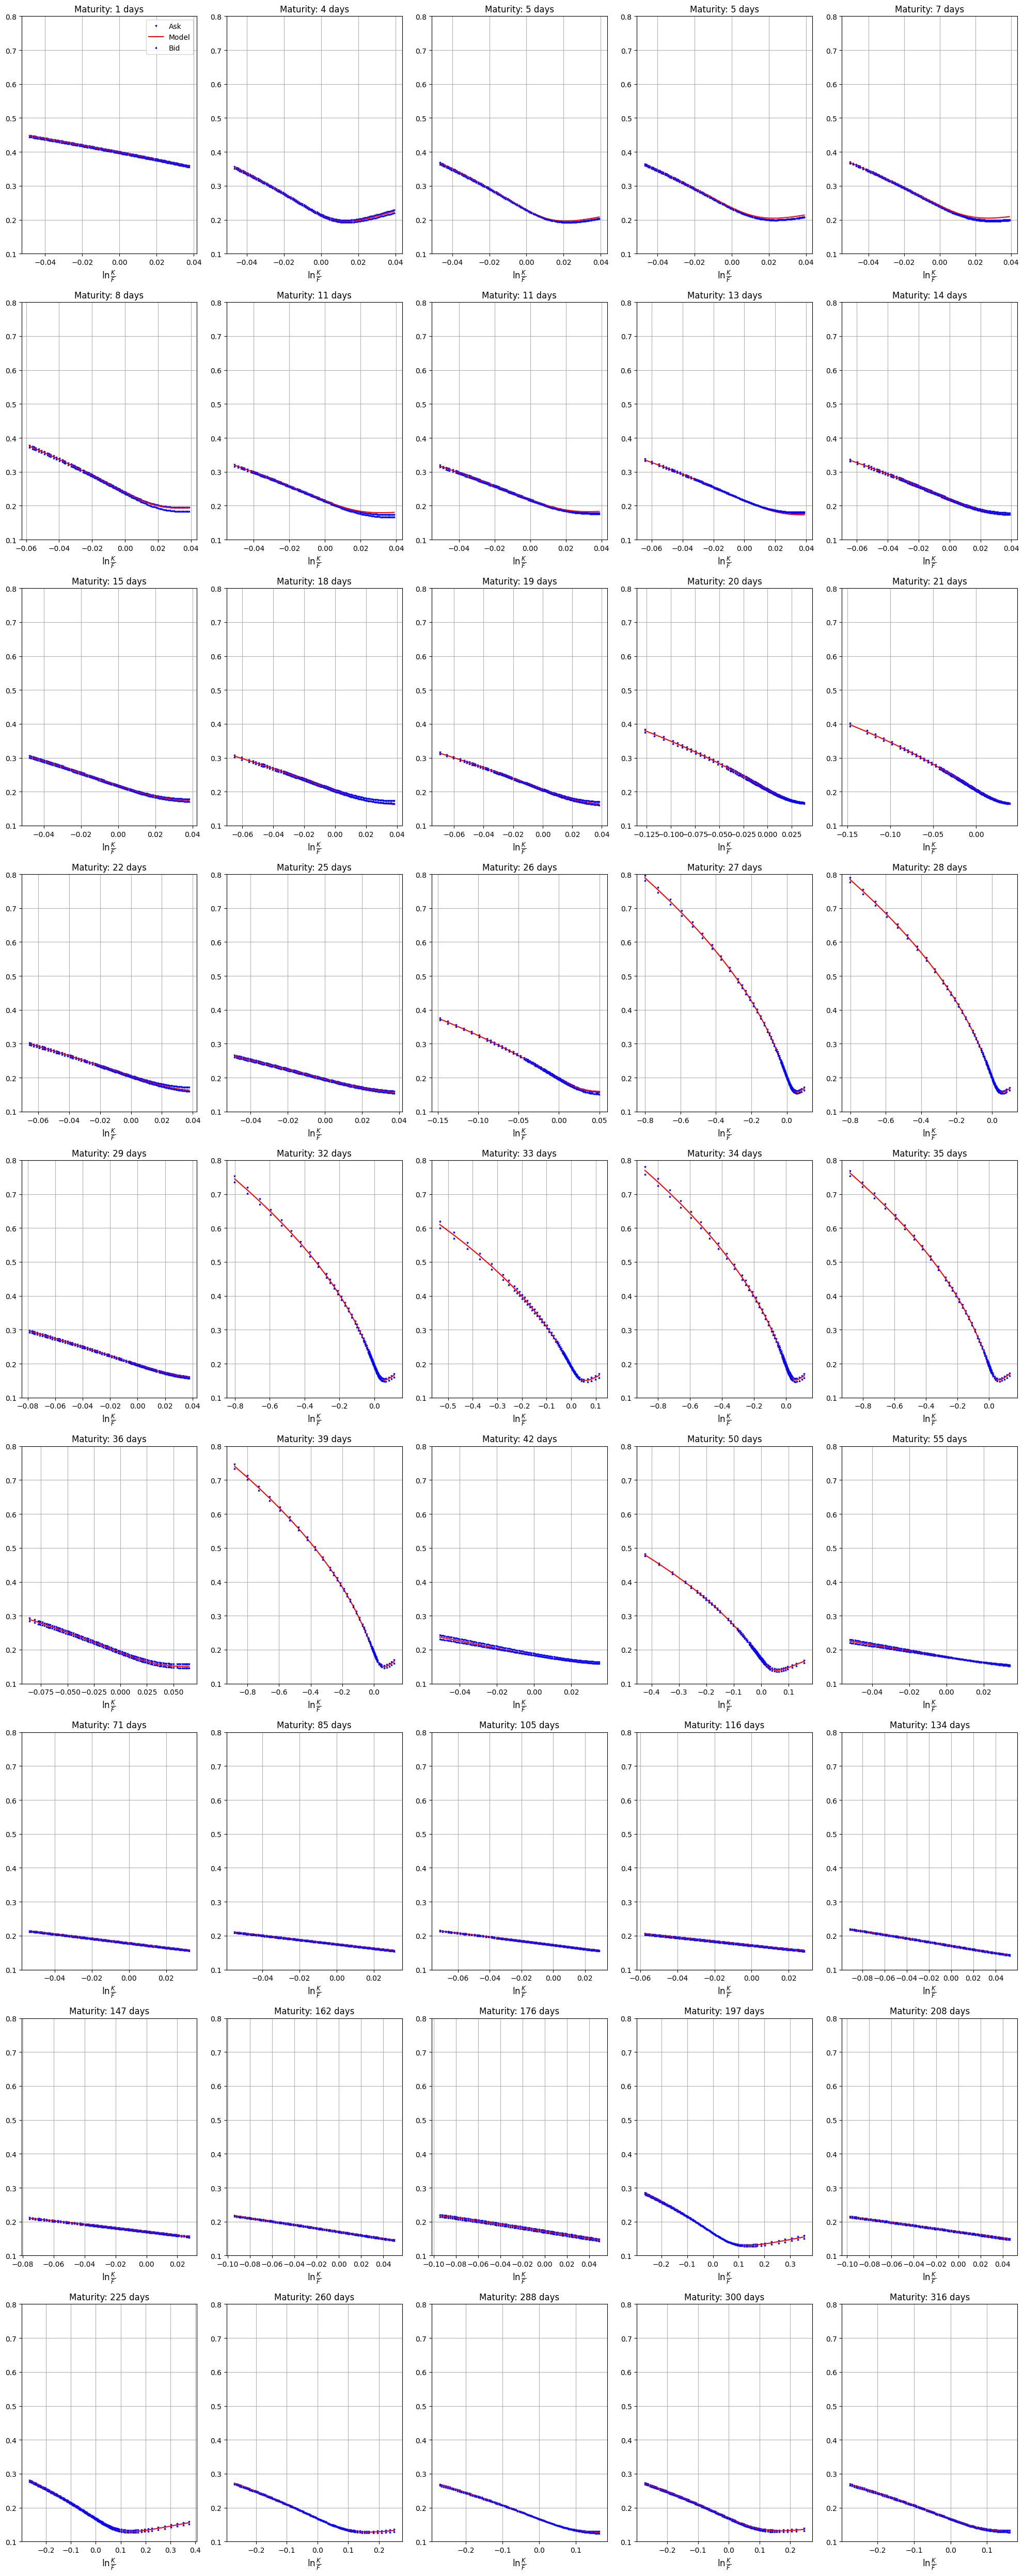

In [29]:
T_vectU_days = (T_vectU * 365).astype(int)
fig, axes = plt.subplots(nRow, nCol, figsize=(20, 50))
axes = axes.flatten()  # Flatten axes array for easy indexing

for t in range(len(T_vectU)):
    pos = (maturity.to_numpy() == T_vectU[t])  # Ensure pos is a NumPy array
    x = np.sort(log_moneyness.to_numpy()[pos])
    idx = np.argsort(log_moneyness.to_numpy()[pos])
    
    IV = model_implied_volatility.to_numpy()[pos][idx]
    IV_a = model_implied_volatility_ask.to_numpy()[pos][idx]
    IV_b = model_implied_volatility_bid.to_numpy()[pos][idx]
    
    ax = axes[t]
    ax.plot(x, IV_a, 'vb', linewidth=1.5, markersize=2, label='Ask')
    ax.plot(x, IV, '-r', linewidth=1.5, label='Model')
    ax.plot(x, IV_b, '^b', linewidth=1.5, markersize=2, label='Bid')
    
    ax.set_title(f'Maturity: {T_vectU_days[t]} days')
    ax.set_ylim([0.1, 0.8])
    ax.set_xlabel(r'$\ln\frac{K}{F}$', fontsize=12)
    ax.grid(True)
    if t == 0:
        ax.legend()
    
fig.tight_layout()
plt.show()

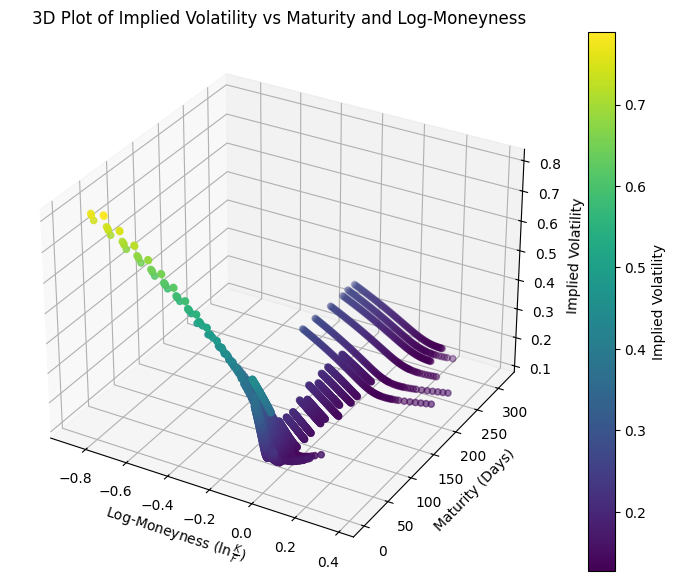

In [30]:
from mpl_toolkits.mplot3d import Axes3D
maturity_days = (maturity.to_numpy() * 365) 
log_moneyness_values = log_moneyness.to_numpy()
implied_vol_values = model_implied_volatility.to_numpy()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D data
sc = ax.scatter(log_moneyness_values, maturity_days, implied_vol_values, c=implied_vol_values, cmap='viridis')

# Add color bar to indicate implied volatility levels
plt.colorbar(sc, ax=ax, label='Implied Volatility')

# Set labels
ax.set_xlabel(r'Log-Moneyness ($\ln\frac{K}{F}$)')
ax.set_ylabel('Maturity (Days)')
ax.set_zlabel('Implied Volatility')
ax.set_title('3D Plot of Implied Volatility vs Maturity and Log-Moneyness')

plt.show()

In [ ]:
svi_params = pd.read_csv(r'/Users/oscarxue/Downloads/svi_parameters.csv')
#svi_params

,Maturity,a,b,rho,m,sigma
0,0.002740,0.158559,-0.056061,0.112164,0.000042,0.000236
1,0.010959,0.045205,-0.275697,0.959220,0.407827,0.037850
2,0.013699,0.052515,-0.338702,0.993523,0.316120,0.038465
3,0.016438,0.055405,-0.328224,0.990911,0.334464,0.041813
4,0.019178,0.058150,-0.343243,0.993127,0.306640,0.041929
5,0.021918,0.056688,-0.365454,0.991701,0.260793,0.037383
6,0.030137,0.046054,-0.355245,1.001374,0.290883,0.032133
7,0.032877,0.047065,-0.348969,0.994322,0.296384,0.033303
8,0.035616,0.046038,-0.368295,0.990657,0.254068,0.029916
9,0.038356,0.047797,-0.366879,0.974142,0.240385,0.030351


In [ ]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):

    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

In [ ]:
#integrand function
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

In [ ]:
#rectangular integration
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [ ]:
from scipy.integrate import quad
from scipy.optimize import minimize
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [ ]:
# This is the calibration function
# heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
# Parameters are v0, kappa, theta, sigma, rho, lambd


# Define variables to be used in optimization
r = merged_df['Interest Rate'].to_numpy('float')
K = merged_df['Strike'].to_numpy('float')
tau = merged_df['Maturity'].to_numpy('float')
P = merged_df['Mid'].to_numpy('float')
S0 = np.full(len(K), 5805) 

params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.1]},
          "kappa": {"x0": 3, "lbub": [1e-3,5]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.1]},
          "sigma": {"x0": 0.3, "lbub": [1e-2,1]},
          "rho": {"x0": -0.8, "lbub": [-1,0]},
          "lambd": {"x0": 0.03, "lbub": [-1,1]},
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]


def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]

    # Attempted to use scipy integrate quad module as constrained to single floats not arrays
    # err = np.sum([ (P_i-heston_price(S0, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 /len(P) \
    #               for P_i, K_i, tau_i, r_i in zip(marketPrices, K, tau, r)])

    # Decided to use rectangular integration function in the end
    err = np.sum( (P-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )

    # Zero penalty term - no good guesses for parameters
    pen = np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )

    return err + pen

In [ ]:
from scipy.optimize import minimize
result = minimize(SqErr, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)
result

/var/folders/9_/mqsyyrcx6n93sgb32yjd96140000gn/T/ipykernel_23937/2597819352.py:19: RuntimeWarning: overflow encountered in exp
  exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
/var/folders/9_/mqsyyrcx6n93sgb32yjd96140000gn/T/ipykernel_23937/2597819352.py:21: RuntimeWarning: invalid value encountered in multiply
  return exp1*term2*exp2
/var/folders/9_/mqsyyrcx6n93sgb32yjd96140000gn/T/ipykernel_23937/2205431838.py:11: RuntimeWarning: invalid value encountered in multiply
  numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 121981.06258724867
       x: [ 3.081e-02  3.839e+00  2.810e-02  3.626e-02 -6.787e-02
            7.210e-01]
     nit: 25
     jac: [ 1.004e+03 -7.118e+00  7.939e+02  7.450e+02 -3.580e+02
           -1.322e+01]
    nfev: 194
    njev: 23

In [ ]:
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
v0, kappa, theta, sigma, rho, lambd

(np.float64(0.030814570761012315),
 np.float64(3.838673842684923),
 np.float64(0.028098096472220477),
 np.float64(0.036259805843446416),
 np.float64(-0.0678670834368166),
 np.float64(0.7210176885921777))

In [ ]:
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r) 

In [ ]:
merged_df['HestonPrice'] = heston_prices
merged_df

,Strike,Moneyness,Bid,Mid,Ask,Last,Change,%Chg,Volume,Open Int,OI Chg,Delta,IV,Type,Last Trade,Maturity,Implied Forward,Interest Rate,Calculated Implied Vol,HestonPrice
0,5520.0,+4.92%,273.50,274.90,276.30,248.81,unch,unch,0,2,unch,0.98111,44.80%,c,03/05/25,0.002740,5804.204849,-0.050000,NaN,282.199795
100,5520.0,-4.92%,0.85,0.90,0.95,1.37,+1.02,+291.43%,467,847,+210,-0.01823,44.48%,p,11:55 ET,0.002740,5804.204849,-0.050000,0.458616,282.199795
1,5525.0,+4.83%,268.50,269.95,271.40,414.47,unch,unch,0,0,unch,0.98009,44.43%,c,03/03/25,0.002740,5804.204849,-0.050000,NaN,278.213339
101,5525.0,-4.83%,0.90,0.95,1.00,1.4,+0.95,+211.11%,361,937,+155,-0.02002,44.47%,p,11:54 ET,0.002740,5804.204849,-0.050000,0.455190,278.213339
2,5530.0,+4.75%,263.30,264.85,266.40,276.04,unch,unch,0,10,+4,0.98136,43.01%,c,03/05/25,0.002740,5804.204849,-0.050000,NaN,274.227676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8427,6950.0,+19.74%,974.60,983.60,992.60,0.00,unch,unch,0,0,unch,0.00000,0.00%,p,NaN,0.865753,5957.949265,0.030039,0.107860,33.159870
8328,6975.0,-20.17%,25.70,26.15,26.60,37.00,unch,unch,0,89,unch,0.09275,11.74%,c,03/03/25,0.865753,5957.949265,0.030039,0.121277,29.255906
8428,6975.0,+20.17%,996.50,1005.55,1014.60,785.51,unch,unch,0,1,unch,0.00000,0.00%,p,01/17/25,0.865753,5957.949265,0.030039,0.106237,29.255906
8329,7000.0,-20.60%,23.70,24.15,24.60,24.70,-3.00,-10.83%,4,"3,362",+2,0.08690,11.71%,c,11:29 ET,0.865753,5957.949265,0.030039,0.120952,25.503603


In [ ]:
def PriceCalibration(Market_Prices, Model_Prices, Bid, Ask):
    #Define error as Bid/Ask spread
    e = 1 / (Ask - Bid) ** 2
    MSE = np.sum(e * ((Market_Prices - Model_Prices) ** 2))
    return MSE
